# DRL Agent training notebook

---

### 1. Start the Environment

The environment is already saved in the workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Create an Agent

For training the agent, I'm using a Neural Network to determine the next action.

It is a simple network:


|                DQN                                                                                |
|:---------------------------------------------------------------------------------------------------|
| Fully Connected Layer 1 (input size = 37 number of states, output size = 64, activation=RELU)     |
| Fully Connected Layer 2 (input size = 64, output size = 4 number of possible actions, activation=linear)|


The optimizer selected is Adam.

The agent uses a Replay buffer that saves the previous action. The buffer length is 100. It saves (state, action, reward, next_action, done) tuples.

To get the next action, I evaluate the local network returning as output the action with the higher probability.

Each training step, the agent save the previous state in the replay buffer and trains the local DQN network using MSE loss function. 

It's important to notice that it saves the parameters in a second network, dqn_target. This is called Fixed Q-Targets. Each action affect the position of the target and it's hard to get close. A solution is to decouple the target position. Basically, we are copying the weights. 

The network was trained 2000 episodes but if the score is higher than 13, it will break.

The paremeters used:

* GAMMA = 0.99            # discount factor
* TAU = 1e-3              # for soft update of target parameters
* LR = 5e-4               # learning rate 





In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
from agent import Agent
import matplotlib.pyplot as plt

from collections import deque
import torch

%matplotlib inline

# Creates the Agent
ag = Agent(state_size=state_size, action_size=action_size, seed=0)



### 4. Train the Agent

Episode 100	Average Score: 0.145151515151515256
Episode 200	Average Score: 1.26
Episode 300	Average Score: 4.21
Episode 400	Average Score: 7.54
Episode 500	Average Score: 8.81
Episode 600	Average Score: 12.47
Episode 625	Average Score: 13.02
Environment solved in 525 episodes!	Average Score: 13.02


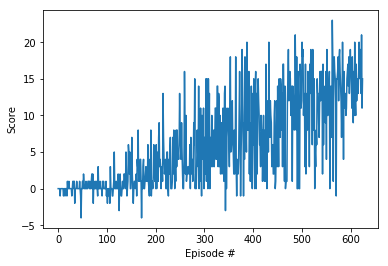

In [7]:


retrain=True

def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()[brain_name].vector_observations[0] 
        score = 0
        for t in range(max_t):
            
            action = ag.get_next_action(state)
            environment = env.step(action)[brain_name]
            
            next_state = environment.vector_observations[0]
            reward = environment.rewards[0]
            done = environment.local_done[0]
            ag.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(ag.dqn_local.state_dict(), 'checkpoint2.pth')
            break
    return scores

if retrain:
    scores = train()
    #torch.save(ag.dqn_local.state_dict(), 'checkpoint.pth')

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 5. Test the Agent and get the score

In [8]:
# I'm loading the saved checkpoint
ag.dqn_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = ag.get_next_action(state)             # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
print("Score: {}".format(score))        

Score: 14.0


I close the environment!

In [9]:
env.close()

## 6. Ideas for future works


Add advanced techiniques in Deep Q Learning like:
* [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)
* [Double Q-learning](https://arxiv.org/abs/1511.06581)
* [Dueling Network Architectures](https://arxiv.org/abs/1509.06461) 